In [12]:
import random
import optuna
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm

# Suppress Optuna's experimental warning for MedianPruner
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

In [13]:
# -----------------------|
# 0) Housekeeping
# -----------------------
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior (slower but stable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [27]:
# ----------------------------------------------------------------------------
# 1. Configuration Grid
# ----------------------------------------------------------------------------
class Config:
    """Centralized configuration for hyperparameters and settings."""
    # --- Data and Splitting ---
    FILE_PATH = r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Multivariate\merged_df_final.csv"
    TARGET_COLUMN = 'Carbon_Price_USD'
    DATE_COLUMN = 'Date'
    VAL_SPLIT_DATE = '2024-04-01'
    
    # --- Optuna Hyperparameter Search Space ---
    N_TRIALS = 1000  # Number of optimization trials
    WINDOW_SIZE_MIN = 2 
    WINDOW_SIZE_MAX = 40
    # MLP specific hyperparameters
    MLP_HIDDEN_LAYERS_MIN = 1
    MLP_HIDDEN_LAYERS_MAX = 3
    MLP_HIDDEN_SIZE_CHOICES = [64, 128, 256]
    
    NUM_GAUSSIANS_MIN = 2
    NUM_GAUSSIANS_MAX = 7
    DROPOUT_MIN = 0.0
    DROPOUT_MAX = 0.4
    LR_MIN = 1e-4
    LR_MAX = 1e-2

    # --- Final Training and Evaluation ---
    NUM_RUNS = 5  # Number of ensemble runs for stability check
    MAX_EPOCHS = 100
    BATCH_SIZE = 32
    CRPS_SAMPLES = 1000 # Number of samples for CRPS calculation

    # --- Prediction Interval Configuration (CHANGE THIS SECTION) ---
    LOWER_QUANTILE = 0.025
    UPPER_QUANTILE = 0.975

In [15]:
# ----------------------------------------------------------------------------
# 2. Device Configuration
# ----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# ----------------------------------------------------------------------------
# 3. MdnModel Definition
# ----------------------------------------------------------------------------
class MdnModel(nn.Module):
    """An MLP base with a Mixture Density Network head."""
    def __init__(self, input_size, hidden_layers, hidden_size, num_gaussians, dropout):
        super(MdnModel, self).__init__()
        
        layers = []
        # Input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        self.mlp = nn.Sequential(*layers)
        
        # MDN Head
        self.z_pi = nn.Linear(hidden_size, num_gaussians)
        self.z_sigma = nn.Linear(hidden_size, num_gaussians)
        self.z_mu = nn.Linear(hidden_size, num_gaussians)

    def forward(self, x):
        # Flatten the input sequence
        flat_x = x.view(x.size(0), -1)
        mlp_out = self.mlp(flat_x)
        
        pi = F.softmax(self.z_pi(mlp_out), dim=1)
        sigma = F.softplus(self.z_sigma(mlp_out)) + 1e-6
        mu = self.z_mu(mlp_out)
        return pi, sigma, mu

In [17]:
# ----------------------------------------------------------------------------
# 4. Helper Functions
# ----------------------------------------------------------------------------
def create_sequences(features, target, window_size):
    """Creates sequences for true forecasting."""
    X_seq, y_seq = [], []
    for i in range(len(features) - window_size):
        X_seq.append(features[i:(i + window_size)])
        y_seq.append(target[i + window_size])
    return np.array(X_seq), np.array(y_seq)

def mdn_loss(pi, sigma, mu, y):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    log_prob = m.log_prob(y)
    weighted_log_prob = log_prob + torch.log(pi)
    log_sum_exp = torch.logsumexp(weighted_log_prob, dim=1)
    return -torch.mean(log_sum_exp)

def calculate_all_metrics(pi, sigma, mu, y_true_tensor, scaler_y,
                          lower_quantile=0.05, upper_quantile=0.95, num_samples_crps=100):
    """
    Calculates PICP, MPIW, CRPS, and prediction bounds from MDN parameters.
    Handles scaling properly (all metrics computed in original scale).
    """
    with torch.no_grad():
        # --- Effective Mean & Variance ---
        effective_mu = torch.sum(pi * mu, dim=1)
        effective_var = torch.clamp(
            torch.sum(pi * (sigma**2 + mu**2), dim=1) - effective_mu**2,
            min=1e-8  # small floor
        )
        effective_sigma = torch.sqrt(effective_var)

        # --- Prediction Intervals ---
        z_lower = norm.ppf(lower_quantile)
        z_upper = norm.ppf(upper_quantile)

        lower_scaled = effective_mu + z_lower * effective_sigma
        upper_scaled = effective_mu + z_upper * effective_sigma

        # Convert to numpy
        lower_scaled_np = lower_scaled.cpu().numpy().reshape(-1, 1)
        upper_scaled_np = upper_scaled.cpu().numpy().reshape(-1, 1)
        y_true_scaled_np = y_true_tensor.cpu().numpy().reshape(-1, 1)

        # --- Fix NaN/Inf ---
        lower_scaled_np = np.nan_to_num(lower_scaled_np, nan=0.0, posinf=1e6, neginf=-1e6)
        upper_scaled_np = np.nan_to_num(upper_scaled_np, nan=0.0, posinf=1e6, neginf=-1e6)
        y_true_scaled_np = np.nan_to_num(y_true_scaled_np, nan=0.0)

        # --- Inverse Transform to Original Scale ---
        y_true = scaler_y.inverse_transform(y_true_scaled_np).flatten()
        lower = scaler_y.inverse_transform(lower_scaled_np).flatten()
        upper = scaler_y.inverse_transform(upper_scaled_np).flatten()

        # --- PICP ---
        is_inside = (y_true >= lower) & (y_true <= upper)
        picp = np.mean(is_inside) * 100

        # --- MPIW (now returns the raw, unnormalized width) ---
        mpiw = np.mean(upper - lower)

        # --- CRPS (sample-based approximation) ---
        comp_idx1 = torch.multinomial(pi, num_samples_crps, replacement=True)
        mu_s1 = torch.gather(mu, 1, comp_idx1)
        sigma_s1 = torch.gather(sigma, 1, comp_idx1)
        samples1 = torch.normal(mu_s1, sigma_s1).cpu().numpy()

        comp_idx2 = torch.multinomial(pi, num_samples_crps, replacement=True)
        mu_s2 = torch.gather(mu, 1, comp_idx2)
        sigma_s2 = torch.gather(sigma, 1, comp_idx2)
        samples2 = torch.normal(mu_s2, sigma_s2).cpu().numpy()

        # Inverse-transform samples
        samples1 = scaler_y.inverse_transform(np.nan_to_num(samples1))
        samples2 = scaler_y.inverse_transform(np.nan_to_num(samples2))

        term1 = np.mean(np.abs(samples1 - y_true.reshape(-1, 1)), axis=1)
        term2 = 0.5 * np.mean(np.abs(samples1 - samples2), axis=1)
        crps = np.mean(term1 - term2)

        return mpiw, picp, crps, lower, upper

In [18]:
# ----------------------------------------------------------------------------
# 5. Data Loading and Preprocessing
# ----------------------------------------------------------------------------
df = pd.read_csv(Config.FILE_PATH)
df[Config.DATE_COLUMN] = pd.to_datetime(df[Config.DATE_COLUMN])
df = df.sort_values(Config.DATE_COLUMN).fillna(method='ffill').reset_index(drop=True)

feature_cols = df.columns.drop([Config.DATE_COLUMN])

train_val_df = df[df[Config.DATE_COLUMN] < Config.VAL_SPLIT_DATE]
test_df = df[df[Config.DATE_COLUMN] >= Config.VAL_SPLIT_DATE]
val_split_index = int(len(train_val_df) * 0.9)
train_df = train_val_df[:val_split_index]
val_df = train_val_df[val_split_index:]

X_train_raw, y_train_raw = train_df[feature_cols].values, train_df[Config.TARGET_COLUMN].values.reshape(-1, 1)
X_val_raw, y_val_raw = val_df[feature_cols].values, val_df[Config.TARGET_COLUMN].values.reshape(-1, 1)
X_test_raw, y_test_raw = test_df[feature_cols].values, test_df[Config.TARGET_COLUMN].values.reshape(-1, 1)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw)
X_val = scaler_x.transform(X_val_raw)
y_val = scaler_y.transform(y_val_raw)
X_test = scaler_x.transform(X_test_raw)
y_test = scaler_y.transform(y_test_raw)

C:\Users\DAIICT I\AppData\Local\Temp\ipykernel_5112\139681524.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.sort_values(Config.DATE_COLUMN).fillna(method='ffill').reset_index(drop=True)


In [19]:
# ----------------------------------------------------------------------------
# 6. Optuna Objective Function
# ----------------------------------------------------------------------------
def objective(trial):
    window_size = trial.suggest_int('window_size', Config.WINDOW_SIZE_MIN, Config.WINDOW_SIZE_MAX)
    hidden_layers = trial.suggest_int('hidden_layers', Config.MLP_HIDDEN_LAYERS_MIN, Config.MLP_HIDDEN_LAYERS_MAX)
    hidden_size = trial.suggest_categorical('hidden_size', Config.MLP_HIDDEN_SIZE_CHOICES)
    
    num_gaussians = trial.suggest_int('num_gaussians', Config.NUM_GAUSSIANS_MIN, Config.NUM_GAUSSIANS_MAX)
    dropout = trial.suggest_float('dropout', Config.DROPOUT_MIN, Config.DROPOUT_MAX)
    lr = trial.suggest_float('lr', Config.LR_MIN, Config.LR_MAX, log=True)

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, window_size)

    if len(X_val_seq) == 0:
        raise optuna.exceptions.TrialPruned()

    X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).to(device)
    
    # Calculate flattened input size for the MLP
    input_size = X_train_seq.shape[1] * X_train_seq.shape[2]
    
    model = MdnModel(
        input_size=input_size, hidden_layers=hidden_layers, hidden_size=hidden_size,
        num_gaussians=num_gaussians, dropout=dropout
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=Config.BATCH_SIZE, shuffle=True)

    for epoch in range(Config.MAX_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pi, sigma, mu = model(xb)
            loss = mdn_loss(pi, sigma, mu, yb)
            loss.backward()
            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        model.eval()
        with torch.no_grad():
            pi_val, sigma_val, mu_val = model(X_val_tensor)
            mpiw, picp, _, _, _ = calculate_all_metrics(
                pi_val, sigma_val, mu_val, y_val_tensor, scaler_y,
                lower_quantile=0.025, upper_quantile=0.975,
                num_samples_crps=100
            )
        
        target_coverage = 95.0
        score = 1000.0 + (target_coverage - picp) if picp < (target_coverage - 1.0) else mpiw
        
        trial.report(score, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return score

In [28]:
# ----------------------------------------------------------------------------
# 7. Run Hyperparameter Optimization
# ----------------------------------------------------------------------------
print(f"\n{'='*20} STARTING HYPERPARAMETER OPTIMIZATION {'='*20}")
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=Config.N_TRIALS)

best_params = study.best_params
optimal_epochs = study.best_trial.last_step + 1
best_window_size = best_params['window_size']

print("\n--- Optuna Study Complete ---")
print(f"Best Score (Validation): {study.best_value:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Optimal epochs found: {optimal_epochs}")

[I 2025-08-25 08:13:17,645] A new study created in memory with name: no-name-04455f0e-033c-4c1c-a63b-32791670a283



==================== STARTING HYPERPARAMETER OPTIMIZATION ====================


[I 2025-08-25 08:13:23,007] Trial 0 finished with value: 39.9586296081543 and parameters: {'window_size': 25, 'hidden_layers': 1, 'hidden_size': 64, 'num_gaussians': 2, 'dropout': 0.2835774105460316, 'lr': 0.0002561479111959383}. Best is trial 0 with value: 39.9586296081543.
[I 2025-08-25 08:13:29,197] Trial 1 finished with value: 1041.774193548387 and parameters: {'window_size': 22, 'hidden_layers': 3, 'hidden_size': 64, 'num_gaussians': 4, 'dropout': 0.36082016446921505, 'lr': 0.0005975224790076571}. Best is trial 0 with value: 39.9586296081543.
[I 2025-08-25 08:13:35,840] Trial 2 finished with value: 1003.4745762711864 and parameters: {'window_size': 25, 'hidden_layers': 2, 'hidden_size': 256, 'num_gaussians': 2, 'dropout': 0.32081435477515846, 'lr': 0.0013885204695805874}. Best is trial 0 with value: 39.9586296081543.
[I 2025-08-25 08:13:42,542] Trial 3 finished with value: 27.24727439880371 and parameters: {'window_size': 25, 'hidden_layers': 1, 'hidden_size': 128, 'num_gaussians'


--- Optuna Study Complete ---
Best Score (Validation): 12.7158
Best Hyperparameters: {'window_size': 16, 'hidden_layers': 1, 'hidden_size': 128, 'num_gaussians': 2, 'dropout': 0.00017926314828662417, 'lr': 0.00430875820569858}
Optimal epochs found: 100


In [29]:
# ----------------------------------------------------------------------------
# 8. Train and Evaluate Ensemble with BEST Hyperparameters
# ----------------------------------------------------------------------------
all_run_results = []

X_full_train_raw = np.concatenate((X_train_raw, X_val_raw), axis=0)
y_full_train_raw = np.concatenate((y_train_raw, y_val_raw), axis=0)
X_full_train = scaler_x.transform(X_full_train_raw)
y_full_train = scaler_y.transform(y_full_train_raw)

X_full_train_seq, y_full_train_seq = create_sequences(X_full_train, y_full_train, best_window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, best_window_size)

X_full_train_tensor = torch.tensor(X_full_train_seq, dtype=torch.float32)
y_full_train_tensor = torch.tensor(y_full_train_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_full_train_tensor, y_full_train_tensor), batch_size=Config.BATCH_SIZE, shuffle=True)

for i in range(Config.NUM_RUNS):
    print(f"\n{'='*20} STARTING STABILITY RUN {i+1}/{Config.NUM_RUNS} {'='*20}")
    
    input_size = X_full_train_seq.shape[1] * X_full_train_seq.shape[2]
    final_model = MdnModel(
        input_size=input_size,
        hidden_layers=best_params['hidden_layers'],
        hidden_size=best_params['hidden_size'],
        num_gaussians=best_params['num_gaussians'],
        dropout=best_params['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])

    print(f"Training final model for {optimal_epochs} epochs...")
    for epoch in range(optimal_epochs):
        final_model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pi, sigma, mu = final_model(xb)
            loss = mdn_loss(pi, sigma, mu, yb)
            loss.backward()
            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
            optimizer.step()

    print(f"Evaluating Run {i+1} on test set...")
    final_model.eval()
    with torch.no_grad():
        pi_test, sigma_test, mu_test = final_model(X_test_tensor)
        
        mpiw, picp, crps, lower, upper = calculate_all_metrics(
            pi_test, sigma_test, mu_test, y_test_tensor, scaler_y,
            lower_quantile=Config.LOWER_QUANTILE, 
            upper_quantile=Config.UPPER_QUANTILE,
            num_samples_crps=Config.CRPS_SAMPLES
        )
        coverage = (Config.UPPER_QUANTILE - Config.LOWER_QUANTILE) * 100
        print(f"  Interval [{Config.LOWER_QUANTILE}, {Config.UPPER_QUANTILE}] ({coverage:.1f}%) -> PICP: {picp:.2f}%, MPIW: {mpiw:.4f}, CRPS: {crps:.4f}")

    all_run_results.append({
        'run': i+1, 'mpiw': mpiw, 'picp': picp, 'crps': crps,
        'lower_bound': lower, 'upper_bound': upper, 'params': best_params
    })


==================== STARTING STABILITY RUN 1/5 ====================
Training final model for 100 epochs...
Evaluating Run 1 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 94.52%, MPIW: 12.0007, CRPS: 1.5567

==================== STARTING STABILITY RUN 2/5 ====================
Training final model for 100 epochs...
Evaluating Run 2 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 98.63%, MPIW: 9.5381, CRPS: 0.9595

==================== STARTING STABILITY RUN 3/5 ====================
Training final model for 100 epochs...
Evaluating Run 3 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 93.15%, MPIW: 7.8534, CRPS: 1.7318

==================== STARTING STABILITY RUN 4/5 ====================
Training final model for 100 epochs...
Evaluating Run 4 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 94.52%, MPIW: 7.1811, CRPS: 0.9375

==================== STARTING STABILITY RUN 5/5 ====================
Training final model for 100 epochs...
Evaluating Run


==================== ANALYSIS ACROSS ALL 5 RUNS ====================

Best hyperparameters saved to 'MDN_Forecasting_best_hyperparameters.csv'

--- Results from Each Run (Interval: [0.025, 0.975]) ---
        mpiw     picp    crps
run                          
1    12.0007  94.5205  1.5567
2     9.5381  98.6301  0.9595
3     7.8534  93.1507  1.7318
4     7.1811  94.5205  0.9375
5     6.0580  94.5205  0.9727

--- Statistical Summary ---
          mpiw     picp    crps
count   5.0000   5.0000  5.0000
mean    8.5263  95.0685  1.2316
std     2.3157   2.0775  0.3819
min     6.0580  93.1507  0.9375
25%     7.1811  94.5205  0.9595
50%     7.8534  94.5205  0.9727
75%     9.5381  94.5205  1.5567
max    12.0007  98.6301  1.7318

Generating and saving the summary plot...


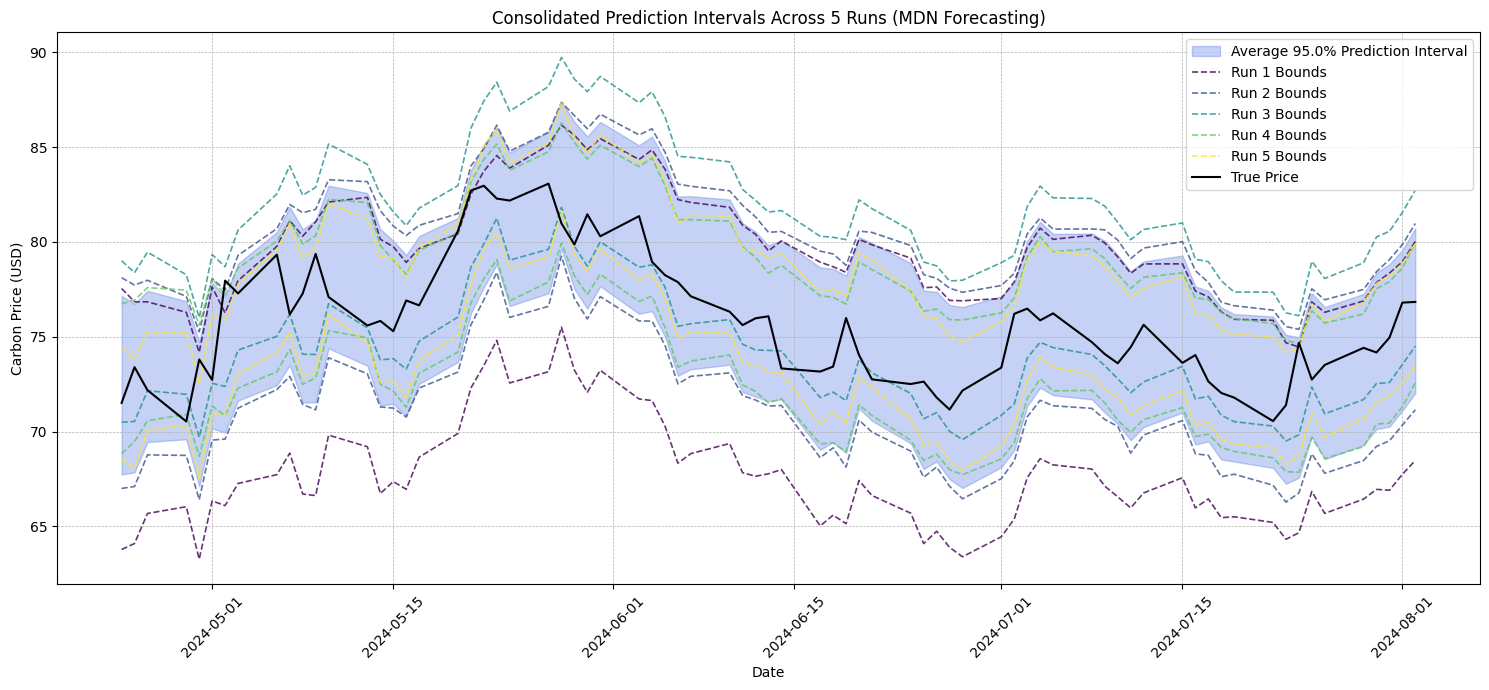


Summary plot saved to 'MDN_Forecasting_Multivariate.png'


In [30]:
# ----------------------------------------------------------------------------
# 9. FINAL ANALYSIS, SAVING, AND PLOTTING
# ----------------------------------------------------------------------------
print(f"\n{'='*20} ANALYSIS ACROSS ALL {Config.NUM_RUNS} RUNS {'='*20}")

params_df = pd.DataFrame([run['params'] for run in all_run_results])
params_df.insert(0, 'run', range(1, Config.NUM_RUNS + 1))
params_df.to_csv('MDN_Forecasting_best_hyperparameters.csv', index=False)
print("\nBest hyperparameters saved to 'MDN_Forecasting_best_hyperparameters.csv'")

metrics_df = pd.DataFrame(all_run_results).drop(columns=['params', 'lower_bound', 'upper_bound']).set_index('run')

print(f"\n--- Results from Each Run (Interval: [{Config.LOWER_QUANTILE}, {Config.UPPER_QUANTILE}]) ---")
print(metrics_df.round(4))

print("\n--- Statistical Summary ---")
print(metrics_df.describe().round(4))

print("\nGenerating and saving the summary plot...")
plt.figure(figsize=(15, 7))

lower_bounds = np.array([run['lower_bound'] for run in all_run_results])
upper_bounds = np.array([run['upper_bound'] for run in all_run_results])
avg_lower_bound = lower_bounds.mean(axis=0)
avg_upper_bound = upper_bounds.mean(axis=0)

plot_dates = test_df[Config.DATE_COLUMN].values[best_window_size:]
y_test_raw_plot = scaler_y.inverse_transform(y_test_seq)

coverage = (Config.UPPER_QUANTILE - Config.LOWER_QUANTILE) * 100
plt.fill_between(
    plot_dates, avg_lower_bound, avg_upper_bound, 
    color='royalblue', alpha=0.3, label=f'Average {coverage:.1f}% Prediction Interval'
)

colors = plt.cm.viridis(np.linspace(0, 1, Config.NUM_RUNS))
for run_index, run_data in enumerate(all_run_results):
    plt.plot(plot_dates, run_data['lower_bound'], color=colors[run_index], linestyle='--', linewidth=1.2, alpha=0.8)
    plt.plot(plot_dates, run_data['upper_bound'], color=colors[run_index], linestyle='--', linewidth=1.2, alpha=0.8, label=f'Run {run_index+1} Bounds')

plt.plot(plot_dates, y_test_raw_plot, color='black', linewidth=1.5, label='True Price')

plt.title(f'Consolidated Prediction Intervals Across {Config.NUM_RUNS} Runs (MDN Forecasting)')
plt.xlabel('Date')
plt.ylabel('Carbon Price (USD)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('MDN_Forecasting_Multivariate.png', dpi=300)
plt.show()
print("\nSummary plot saved to 'MDN_Forecasting_Multivariate.png'")